Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.5175 - loss: 1.4028 - val_accuracy: 0.5783 - val_loss: 1.1208 - learning_rate: 0.0010
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.8015 - loss: 0.5579 - val_accuracy: 0.7580 - val_loss: 0.7585 - learning_rate: 0.0010
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8639 - loss: 0.3848 - val_accuracy: 0.8333 - val_loss: 0.4492 - learning_rate: 0.0010
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.8943 - loss: 0.3027 - val_accuracy: 0.8572 - val_loss: 0.4019 - learning_rate: 0.0010
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.9044 - loss: 0.2696 - val_accuracy: 0.8312 - val_loss: 0.4201 - learning_rate: 0.0010
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.9200 - loss: 0.2340 - val_accuracy: 0.8971 - val_loss: 0.2770 - learning_rate: 0.0010
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.9

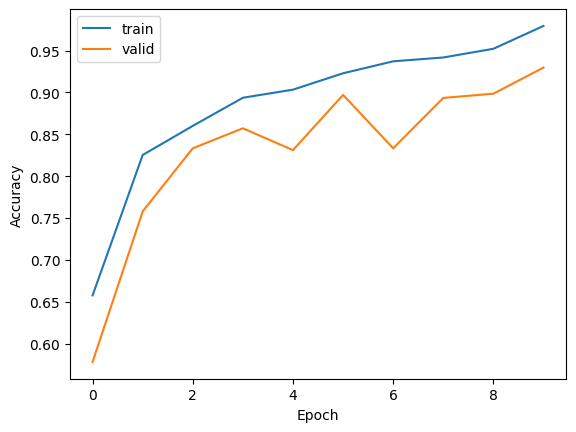

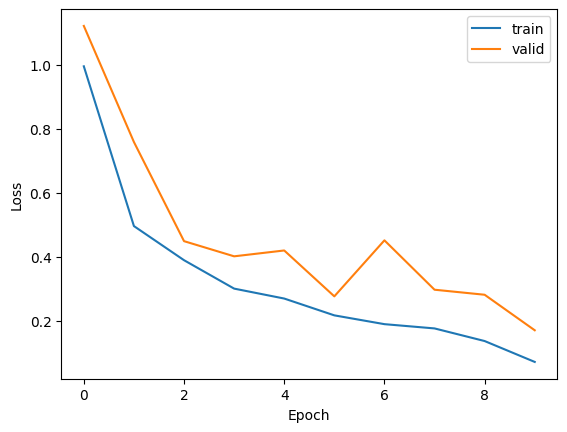

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9464 - loss: 0.1631
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


In [10]:
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


dataDirectory = "/kaggle/input/natural-images/natural_images/"

data = []
labels = []

for label in os.listdir(dataDirectory):
    path = "/kaggle/input/natural-images/natural_images/{0}/".format(label)
    folderData = os.listdir(path)
    for imagePath in folderData:
        img = cv2.imread(path + imagePath)
        img = cv2.resize(img, (32, 32))
        data.append(img)
        labels.append(label)
        
data = np.array(data)
labels = np.array(labels)
data.shape, labels.shape
labelEncoder = LabelEncoder()
labels = labelEncoder.fit_transform(labels)
labels = to_categorical(labels)
data.shape, labels.shape

rand = np.arange(len(data))
np.random.shuffle(rand)

data = data[rand]
labels = labels[rand]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

model = Sequential([
    Conv2D(32, (3, 3), padding="same"),
    BatchNormalization(),
    LeakyReLU(0.001),
    Conv2D(32, (3, 3)),
    BatchNormalization(),
    LeakyReLU(0.001),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), padding="same"),
    BatchNormalization(),
    LeakyReLU(0.001),
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    LeakyReLU(0.001),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), padding="same"),
    BatchNormalization(),
    LeakyReLU(0.001),
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    LeakyReLU(0.001),
    MaxPooling2D((2, 2)),
    
    Dropout(0.25),
    Flatten(),
    Dense(128),
    BatchNormalization(),
    LeakyReLU(0.001),
    Dropout(0.5),
    Dense(8, activation="softmax")
])

# Use the Adam optimizer with a reduced learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Learning rate reduction callback
reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    validation_split=0.25,
    batch_size=32,
    callbacks=[reduceLr]
)

historyDf = pd.DataFrame(history.history)
historyDf.head()

plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.show()

plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.show()

model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)